# Installation de PySpark

Les cellules cachées ci-dessous installent tous les prérequis nécessaires à l'utilisation d'une session spark, qui sera accessible via la variable `spark` dans les parties suivantes

## Step 1 - Mounting Drive folder as local repo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 2 - Setting up PySpark on Colab

In [ ]:
#@title
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
#@title
!pip install -q pyspark

In [ ]:
#@title
!pip install -q findspark

In [ ]:
#@title
import findspark
findspark.init()

In [ ]:
#@title
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
#@title
spark

# Chapitre 2 - Apache Spark : la gestion de données par partitionnement, distribution et parallélisation 

## Introduction : l'apparition du Big Data

Le Big Data est souvent caractérisé par trois grands principes, appelés les "3V" :    


*   **Vélocité**
*   **Volume**
*   et **Variété**

On considère un volume de données comme étant massif lorsque son traitement n'est plus réalisable par des méthodes traditionnelles telles qu'explorées dans le Chapitre 1 (de l'ordre du GB ou de la dizaine de GB). On parle de variété de données lorsque le nombre de variables différentes (souvent matérialisées par des colonnes dans des données tabulaires) devient important. Et enfin, on parle de vélocité lorsque la fréquence d'ingestion des données dépasse le cadre d'un traitement possiblement manuel.

Dans les deux prochains chapitres, nous allons explorer deux technologies permettant de répondre aux challenges apportés par ces trois grands principes.

Au début des années 2000, Google se voit confronté à ces trois V pour la première fois. Là où la plupart de ses concurrents auront fait le choix d'ignorer certains de ces challenges, en se concentrant sur l'un d'entre eux (exemple : Yahoo avait initialement fait le choix d'ignorer la variété des données en proposant un "annuaire" des sites web, ordonnés de manière alphabétique, plutôt que de proposer un moteur de recherche pertinent), Google aura fait le choix de démocratiser un principe algorithmique appellé le MapReduce. 

Concept emprunté à la programmation fonctionnelle, le MapReduce permet de manipuler de grandes quantités de données en les distribuant dans un cluster de machines pour être traitées, à travers deux opérations pouvant être parallélisées à grande échelle :     


*   le **map**, qui consiste à appliquer une fonction à un ensemble de vecteurs, afin d'obtenir en sortie, une donnée de mêmes dimensions, à laquelle aura été appliquée une opération ou une combinaison d'opérations élémentaires simples.
*   le **reduce**, qui consiste à réduire la dimension d'un ensemble de données d'une dimension, en réduisant un vecteur 1D à une donnée unique par une ou plusieurs opérations d'aggrégation.

En 2006, l'Apache Software Foundation sortira la première version d'Hadoop, bibliothèque Java open-source, combinant la puissance d'un paradigme MapReduce avec un système de stockage distribué nommé HDFS (pour *Hadoop Distributed File System*). Si le MapReduce permet de traiter facilement une grande variété de données, le HDFS permettra de tirer avantage de formats de stockages vastes et peu onéreux (les disques durs) pour traiter un grand volume de données. Deux des trois V étaient donc traités.

Afin de rendre l'usage d'Hadoop plus appliqué au traitement de la donnée en temps réel, la même Apache Software Foundation mettra à disposition du grand public en 2014 la bibilothèque multi-langages Apache Spark, qui serivra de cadre applicatif de traitements Big Data pour effectuer des analyses complexes à grande échelle.

Développé nativement en Scala (langage fonctionnel surcouche de Java), Apache Spark met à disposition de ses utilisateurs des APIs en Java, R et Python. Dans ce chapitre 2, nous explorerons le fonctionnement de Spark à travers ces APIs Python nommées **pyspark**.


## Section 1 - Introduction aux RDDs

Les **RDD**s, acronyme de **Resilient Distributed Dataset** est le bloc fondamental de Spark. Il s'agit d'une collection d'objets distribuée immuable et tolérante aux erreurs matérielles. L'immuabilité d'un RDD signifie qu'une fois un RDD créé, il ne peut plus être changé. Chaque enregistrement d'un RDD est divisé en **partitions logiques**, qui peuvent être utilisées sur différents noeuds d'un cluster.

Pour se rapporter à des principes connus, un RDD est similaire à une liste Python, à la différence qu'un RDD peut voir ses calculs distribués sur plusieurs serveurs physiquement distincts, serveurs que l'on nommera "noeuds", là où une liste Python ne vit qu'au sein d'un seul et unique processus.

De plus, les RDDs permettent de s'abstraire du partitionnement et de la distribution manuelle des données à travers différents noeuds de calcul, ne demandant à son utilisateur que de fournir la suite de transformations à effectuer, sans avoir à se soucier sur quels noeuds les calculs seront parallélisés.



### 1 - *Paralléliser* une collection de données existantes

La manière la plus simple de créer un RDD est de partir d'une collection de données connues, telle qu'une liste Python et de demander à Spark de "paralléliser" cette collection et d'en faire un RDD. Pour cela, nous avons besoin d'une session Spark active. Les cellules cachées en haut de ce notebook ont déjà créé une session Spark active, stockée dans la variable `spark`.

In [ ]:
# Affiche les métadonnées de la session active
spark

La fonction `sparkContext.parallelize` permet de paralléliser un itérable Python à travers plusieurs noeuds. La fonction `.collect`, méthode appliquée à la classe Python RDD, permet de rassembler les données des divers noeuds sur laquelle elle est distribuée et de la présenter à l'utilisateur.

#### Exercice 1

Créer une liste Python et parallélisez-là dans un RDD. Présentez les données grâce à la fonction de collection

In [ ]:
liste = range(0,10)
rdd_test = spark.sparkContext.parallelize(liste)
rdd_test.collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

La fonction `getNumPartitions` appliquée à un RDD permet de savoir le nombre de de noeuds utilisés pour paralléliser la donnée. Les fonctions `.repartition` et `.coalesce` de la classe Python RDD, une fois appliquée à un RDD, prennent en paramètre un nombre entier, et créent un nouveau RDD distribué sur le nombre indiqué de partitions.

In [ ]:
# Exemple
rdd = spark.sparkContext.parallelize(range(0,20))
print('Mon nombre de partitions est ', rdd.getNumPartitions())
print(rdd.glom().collect())  # La fonction glom permet d'aggréger les données d'une partition avant de les collecter

# Exemple avec 10 partitions
rdd = spark.sparkContext.parallelize(range(0,20), 10)  # Remarquez que l'on peut spécifier, en second paramètre de parallelize, le nombre de noeuds 
print('Mon nombre de partitions est ', rdd.getNumPartitions())
rdd.glom().collect()

Mon nombre de partitions est  1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]
Mon nombre de partitions est  10


[[0, 1],
 [2, 3],
 [4, 5],
 [6, 7],
 [8, 9],
 [10, 11],
 [12, 13],
 [14, 15],
 [16, 17],
 [18, 19]]

In [ ]:
rdd.repartition(5).glom().collect()

[[12, 13, 16, 17],
 [0, 1, 18, 19],
 [4, 5, 6, 7, 14, 15],
 [2, 3],
 [8, 9, 10, 11]]

In [ ]:
rdd.coalesce(5).glom().collect()

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19]]

Constatez la différence de résultats entre les fonctions `repartition` et `coalesce`. La différence entre les deux fonctions tient dans la répartition faite sur les nouvelles partitions. `repartition` mélange aléatoirement les données sur les cinq noeuds, afin de rendre les partitions les plus "homogènes" possibles. Ce traitement aléatoire est bien plus coûteux que `coalesce` qui divisera équitablement et séquentiellement chacun des éléments du rdd initial dans l'ordre, à travers toutes les partitions.

#### Exercice 2

Créez un RDD à partir d'une liste Python comprenant 2 000 000 d'éléments, distribués sur 100 partitions.

Utilisez les fonctions `repartition` et `coalesce` pour réarranger les données sur 20 partitions. Constatez les temps de traitements différents

In [ ]:
# création du RDD
liste_2m = range(0,2000000)
rdd_2m = spark.sparkContext.parallelize(liste_2m, 100)
rdd_2m.getNumPartitions()

100

In [ ]:
# utilisation de repartition
rdd_2m.repartition(20).glom().collect()

[[190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397,
  398,
  399,
  590,
  591,
  592,
  593,
  594,
  595,
  596,
  597,
  598,
  599,
  790,
  791,
  792,
  793,
  794,
  795,
  796,
  797,
  798,
  799,
  990,
  991,
  992,
  993,
  994,
  995,
  996,
  997,
  998,
  999,
  1190,
  1191,
  1192,
  1193,
  1194,
  1195,
  1196,
  1197,
  1198,
  1199,
  1390,
  1391,
  1392,
  1393,
  1394,
  1395,
  1396,
  1397,
  1398,
  1399,
  1590,
  1591,
  1592,
  1593,
  1594,
  1595,
  1596,
  1597,
  1598,
  1599,
  1790,
  1791,
  1792,
  1793,
  1794,
  1795,
  1796,
  1797,
  1798,
  1799,
  1990,
  1991,
  1992,
  1993,
  1994,
  1995,
  1996,
  1997,
  1998,
  1999,
  2190,
  2191,
  2192,
  2193,
  2194,
  2195,
  2196,
  2197,
  2198,
  2199,
  2390,
  2391,
  2392,
  2393,
  2394,
  2395,
  2396,
  2397,
  2398,
  2399,
  2590,
  2591,
  2592,
  2593,
  2594,
  2595,
  2596,
  2597,
  2598,
  2599,
  2790,
  

In [ ]:
# utilisation de coalesce
rdd_2m.coalesce(20).glom().collect()

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

### 2 - Sauvegarder un RDD

Les partitions d'un RDD peuvent être exportées et persistées sur un système de stockage via plusieurs fonctions. Les fonctions `saveAsTextFile` et `textFile` permettent respectivement de sauvegarder et de charger un RDD vers un dossier. Ce dossier contiendra toutes les partitions du RDD sous forme de fichiers.

#### Exercice 3

Générez un RDD à partir d'une liste de 2 000 000 de `int`, répartis sur 50 partitions. Exportez ce RDD vers un dossier nommé "test_RDD". Puis chargez de nouveau ce RDD. Calculez ensuite le maximum de votre RDD, grâce à la fonction `.max()`

In [ ]:
rdd_save = spark.sparkContext.parallelize(liste_2m, 50)
!rm -r /content/test_RDD
rdd_save.saveAsTextFile("./test_RDD")

rm: cannot remove '/content/test_RDD': No such file or directory


In [ ]:
rdd_load = spark.sparkContext.textFile("/content/test_RDD")

print("max du rdd save = ", rdd_save.max())
print("Comparaison avec le rdd load : ")
print("max = ", rdd_load.max())
print("map(int).max = ", rdd_load.map(int).max())
print("count = ", rdd_load.count())

max du rdd save =  1999999
Comparaison avec le rdd load : 
max =  999999
map(int).max =  1999999
count =  2000000


####Exercice 4

Calculez les revenus médians maximum et les valeurs médianes maximun des habitations californiennes.

Dans une cellule, utilisez le df Pandas `data`, dans l'autre cellule, utilisez Spark, via le rdd `rdd_data`.

In [ ]:
import pandas as pd
data = pd.read_csv("/content/sample_data/california_housing_train.csv").sample(frac=10, replace=True)
rdd_data = spark.createDataFrame(data).rdd

In [ ]:
# Voici à quoi ressemble une "ligne" d'un RDD
rdd_data.first()

Row(longitude=-116.31, latitude=33.66, housing_median_age=7.0, total_rooms=4497.0, total_bedrooms=831.0, population=2248.0, households=713.0, median_income=3.6354, median_house_value=98000.0)

In [ ]:
# Pour sélectionner la i-ième colonne d'un RDD, faites comme suit :
i = 3 # Ici on sélectionne le total des pièces d'une habitation
rdd_data.map(lambda x: x[i])

PythonRDD[76] at RDD at PythonRDD.scala:53

In [ ]:
# Les max avec Pandas
print("Avec Pandas :")

print("max des revenues médians : ", data["median_income"].max())
print("max des valeurs médianes des habitations : ", data["median_house_value"].max())

Avec Pandas :
max des revenues médians :  15.0001
max des valeurs médianes des habitations :  500001.0


In [ ]:
# Les max avec Spark
print("Avec Spark")
k = 7 # Colonne "median_income"
j = 8 # Colonne "median_house_value"
print("max des revenues médians : ", rdd_data.map(lambda x: x[k]).max())
print("max des valeurs médianes des habitations : ", rdd_data.map(lambda x: x[j]).max())

Avec Spark
max des revenues médians :  15.0001
max des valeurs médianes des habitations :  500001.0


## Section 2 - Les transformations sur RDDs


Comme décrit plus haut, un RDD n'est ni plus ni moins qu'une collection d'objets parallélisés sur plusieurs noeuds. Pour accéder de manière optimisée à cette donnée distribuée, il est de bon ton de ne pas récupérer l'intégralité des données de toutes les partitions à chaque fois que l'on souhaite y accéder. Cela ferait perdre tout l'intérêt de cette distribution résiliente.

Ainsi, inspiré par la programmation fonctionnelle, Spark propose diverses transformations sur ses RDDs, qui permettront de ne récupérer que la donnée dont on a précisément besoin, le tout en s'affranchissant des contraintes liées à cette distribution.

Filtre, transformation, duplication, sélection, analyse, Spark (et pySpark pour son API Python) propose un ensemble de méthodes à appliquer à un RDD, qui permettent de diminuer la quantité de données récoltées et optimiser le traitement.

De plus, toutes ses transformations tirent avantage de ce que l'on appelle le *lazy loading*. Ainsi, une suite de transformations appliquées à un RDD ne sera en réalité que "préparée" en avance, attendant qu'une fonction de collection soit réellement appelée pour exécuter la liste de transformations préparées.

Ci-dessous un exemple.

In [ ]:
rdd = spark.sparkContext.parallelize(range(0, 3000000))

In [ ]:
rdd = rdd.map(lambda x: x**2)

Constatez que malgré le fait que mon RDD contienne 3 millions d'éléments, la mise au carré de chacun des éléments du RDD semble instantanée. En vérité, Spark n'a pas exécuté la fonction permettant de mettre au carré chacun des éléments, mais simplement préparé l'opération. Ainsi, en fonction de la méthode de collection qui sera appelée par la suite, Spark n'exécutera l'opération que sur les objets concernés par la collection.

In [ ]:
rdd.take(5)

[0, 1, 4, 9, 16]

In [ ]:
rdd.collect()

[0,
 1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361,
 400,
 441,
 484,
 529,
 576,
 625,
 676,
 729,
 784,
 841,
 900,
 961,
 1024,
 1089,
 1156,
 1225,
 1296,
 1369,
 1444,
 1521,
 1600,
 1681,
 1764,
 1849,
 1936,
 2025,
 2116,
 2209,
 2304,
 2401,
 2500,
 2601,
 2704,
 2809,
 2916,
 3025,
 3136,
 3249,
 3364,
 3481,
 3600,
 3721,
 3844,
 3969,
 4096,
 4225,
 4356,
 4489,
 4624,
 4761,
 4900,
 5041,
 5184,
 5329,
 5476,
 5625,
 5776,
 5929,
 6084,
 6241,
 6400,
 6561,
 6724,
 6889,
 7056,
 7225,
 7396,
 7569,
 7744,
 7921,
 8100,
 8281,
 8464,
 8649,
 8836,
 9025,
 9216,
 9409,
 9604,
 9801,
 10000,
 10201,
 10404,
 10609,
 10816,
 11025,
 11236,
 11449,
 11664,
 11881,
 12100,
 12321,
 12544,
 12769,
 12996,
 13225,
 13456,
 13689,
 13924,
 14161,
 14400,
 14641,
 14884,
 15129,
 15376,
 15625,
 15876,
 16129,
 16384,
 16641,
 16900,
 17161,
 17424,
 17689,
 17956,
 18225,
 18496,
 18769,
 19044,
 19321,
 19600,
 19881,
 20164,
 2

Constatez ci-dessus la différence considérable de temps d'exécution des deux commandes de collection des données. La première permet d'accéder aux 5 premiers éléments du RDD. Ainsi, seuls 5 calculs seront effectués avant de délivrer la donnée. A l'opposé, en appelant la fonction `.collect`, on demande à Spark de délivrer l'intégralité des données du RDD, ce qui le force à effectuer le calcul pour chacun des 3 millions d'éléments du RDD.

Tout l'objectif des transformations sur les RDDs Spark sera de minimiser le nombre réel de calculs à effectuer, en préparant une ou une série de transformations sur notre RDD avant de collecter la donnée.

Dans les paragraphes suivants, nous explorerons ensemble quelques transformations courantes sur les RDDs. Pour cela, considérons l'exemple suivant comme RDD sur lequel nous allons appliquer nos transformations successives.

In [ ]:
rdd = spark.sparkContext.parallelize([
    "Project Gutenberg’s",
    "Alice’s Adventures in Wonderland",
    "Project Gutenberg’s",
    "Adventures in Wonderland",
    "Project Gutenberg’s"
])

### 1 - `.map` et `.flatMap`

La fonction `.map` appliquée sur un RDD applique une fonction à chacun des élements du RDD et retourne un nouveau RDD (rappelons-nous qu'un RDD est immuable et que toute opération retourne en réalité un nouveau RDD).

Exemple : dans le code ci-dessous, je cherche à diviser chacune de mes chaînes de caractères en mots uniques. Pour cela, on utilise la fonction built-in de Python sur une `str` nommée `.split` qui retourne une liste de `str` séparées par un séparateur donné en paramètre (ici un espace) et supprime le séparateur de ces chaînes.

In [ ]:
rdd2 = rdd.map(lambda x: x.split(" "))
rdd2.collect()

[['Project', 'Gutenberg’s'],
 ['Alice’s', 'Adventures', 'in', 'Wonderland'],
 ['Project', 'Gutenberg’s'],
 ['Adventures', 'in', 'Wonderland'],
 ['Project', 'Gutenberg’s']]

In [ ]:
def split_espace(x):
    return x.split(' ')

rdd2 = rdd.map(split_espace)
rdd2.collect()

[['Project', 'Gutenberg’s'],
 ['Alice’s', 'Adventures', 'in', 'Wonderland'],
 ['Project', 'Gutenberg’s'],
 ['Adventures', 'in', 'Wonderland'],
 ['Project', 'Gutenberg’s']]

Comme vous pouvez le constater, on a bien récupéré une liste de liste de chaînes de caractères, séparées autour de leurs anciens espaces.

Mettons qu'à partir du RDD original, on souhaite appliquer la même opération à mon RDD, mais tout en souhaitant que les mots extraits constituent des entrées uniques dans notre RDD. 

La fonction `.flatMap` est faite pour cela. De manière similaire à `.map`, `.flatmMap` applique une opération à chacun des éléments du RDD, mais en plus, va "dérouler" tout itérable dans le résultat du RDD (par itérable en Python, on entend tout ce sur lequel on peut appliquer un `for` tels que les `list`, les `tuple`, etc...), afin de constituer un ensemble d'éléments atomiques dans le RDD final.

#### Exercice 5

En utilisant la fonction `.flatMap` sur le RDD original, faites en sorte que chaque mot consitue une entrée individuelle dans un nouveau RDD.

In [ ]:
rdd3 = rdd.flatMap(lambda x: x.split(" "))
rdd3.collect()

['Project',
 'Gutenberg’s',
 'Alice’s',
 'Adventures',
 'in',
 'Wonderland',
 'Project',
 'Gutenberg’s',
 'Adventures',
 'in',
 'Wonderland',
 'Project',
 'Gutenberg’s']

#### Exercice 6

En utilisant la fonction `.map` sur le RDD en sortie de l'exercice 5, initialisez un nouveau RDD où chaque mot sera le premier élément d'un tuple, avec un compteur à 1 en tant que deuxième élément de ce tuple, comme dans l'image ci-dessous.

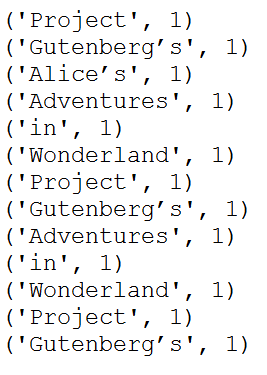

In [ ]:
rdd4 = rdd3.map(lambda x: (x,1))
rdd4.collect()

[('Project', 1),
 ('Gutenberg’s', 1),
 ('Alice’s', 1),
 ('Adventures', 1),
 ('in', 1),
 ('Wonderland', 1),
 ('Project', 1),
 ('Gutenberg’s', 1),
 ('Adventures', 1),
 ('in', 1),
 ('Wonderland', 1),
 ('Project', 1),
 ('Gutenberg’s', 1)]

### 2- `.reduce` et `.reduceByKey`

La fonction `.reduce` renvoie une valeur unique qui est lié à une opération réduisant l'intégralité du RDD à cette unique valeur. Elle prend en paramètres une fonction à deux valeurs et qui n'en renvoie qu'une. Elle appliquera ensuite en cascade cette opération sur l'intégralité des éléments du RDD, pour ne retourner qu'une valeur finale.

Un exemple parlant est la fonction "factorielle". Voici une implémentation de factorielle(100) en Spark.

In [ ]:
rdd_fact = spark.sparkContext.parallelize(range(1, 100 + 1))
rdd_fact.reduce(lambda a,b: a*b)

93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000

La fonction `.reduceByKey`, quant à elle, applique un principe similaire mais qui retourne toutefois un nouveau RDD (transformation toujours appliquée suivant le principe du *lazy loading*). Elle part du principe qu'une entrée d'un RDD est un couple "clé-valeur" sous forme de `tuple` ou de `list` à deux éléments, se servant de la première valeur comme "clé". Elle recherchera ainsi tous les éléments ayant des clés identiques puis appliquera la fonction `.reduce` sur les sous-RDDs formés par les "valeurs" possédant des clés identiques.

#### Exercice 7

A partir du RDD généré dans l'exercice 6, en utilisant la fonction `.reduceByKey` retourner un nouveau RDD qui aura pour éléments des tuples de deux éléments. Le premier élément sera la chaîne de caractères et le second le nombre de fois qu'elle apparaît.

In [ ]:
rdd_ex7 = rdd4.reduceByKey(lambda a,b : a+b)
rdd_ex7.collect()

[('Project', 3),
 ('Gutenberg’s', 3),
 ('Alice’s', 1),
 ('Adventures', 2),
 ('in', 2),
 ('Wonderland', 2)]

#### Exercice 8

A partir du RDD généré dans l'exercice 7, via la fonction `.map`, inverser l'ordre des valeurs de chaque tuple, de manière à ce que la clé devienne valeur et la valeur devienne clé.

In [ ]:
rdd_ex8 = rdd_ex7.map(lambda x: (x[1],x[0]))
rdd_ex8.collect()

[(3, 'Project'),
 (3, 'Gutenberg’s'),
 (1, 'Alice’s'),
 (2, 'Adventures'),
 (2, 'in'),
 (2, 'Wonderland')]

### 3 - `.sortBy` et `.sortByKey`

La fonction `.sortByKey` permet de trier un RDD suivant la clé. Un paramètre `ascending` par défaut à `True` définit si le tri doit être ascendant ou desendant. Spécifier `False` rendra le tri descendant. 

#### Exercice 9
A partir du résultat de l'exercice 8, trier de manière descendante les mots les plus utilisés, en utilisant la fonction `.sortByKey`

In [ ]:
rdd_ex9 = rdd_ex8.sortByKey(False)
rdd_ex9.collect()

[(3, 'Project'),
 (3, 'Gutenberg’s'),
 (2, 'Adventures'),
 (2, 'in'),
 (2, 'Wonderland'),
 (1, 'Alice’s')]

La fonction `.sortBy` s'affranchit du principe de concept de couple clé-valeur, elle prend en paramètre une fonction de sélection retournant l'élément de l'objet qui doit être utilisé comme base de la comparaison pour le tri. Elle a aussi en second paramètre, le même paramètre `ascending` permettant de définir l'ascension ou la descente du tri.

Voici un exemple. Dans le RDD suivant, on a une liste de personnes, avec un nom, un prénom et une année de naissance dans un dictionnaire.

In [ ]:
rdd_personnes = spark.sparkContext.parallelize([
    {
        "nom": "Owens",
        "prenom": "Nigel",
        "annee_naissance": 1971
    },
    {
        "nom": "Barnes",
        "prenom": "Wayne",
        "annee_naissance": 1979
    },
    {
        "nom": "Poite",
        "prenom": "Romain",
        "annee_naissance": 1975
    }
])

Pour trier ce RDD de la personne la plus âgée à la plus jeune, on doit effectuer l'opération suivante : 

In [ ]:
rdd_personnes.sortBy(lambda x: x['annee_naissance']).collect()

[{'annee_naissance': 1971, 'nom': 'Owens', 'prenom': 'Nigel'},
 {'annee_naissance': 1975, 'nom': 'Poite', 'prenom': 'Romain'},
 {'annee_naissance': 1979, 'nom': 'Barnes', 'prenom': 'Wayne'}]

#### Exercice 10
En se basant cette fois sur le résultat de l'exercice 7, réalisez le même exercice que l'exercice 9, mais en utilisant cette fois la fonction `.sortBy`

In [ ]:
rdd_ex10 = rdd_ex7.sortBy(lambda x: x[1], False)
rdd_ex10.collect()

[('Project', 3),
 ('Gutenberg’s', 3),
 ('Adventures', 2),
 ('in', 2),
 ('Wonderland', 2),
 ('Alice’s', 1)]

### 4 - `.filter`

La fonction `.filter` prend en paramètres un prédicat (une fonction qui retourne un booléen) et retourne un nouveau RDD contenant tous les éléments du RDD original satisfaisant le prédicat.

#### Exercice 11

A partir du RDD généré dans l'exercice 10, retournez un nouveau RDD ne contenant que les tuples dont le mot contient un "a" minuscule ou majuscule.

In [ ]:
rdd_ex11 = rdd_ex10.filter(lambda x: "a" in x[0].lower())
rdd_ex11.collect()

[('Adventures', 2), ('Wonderland', 2), ('Alice’s', 1)]

### 5 - Transformations réduites vs transformations étendues

De toutes les transformations possibles en Spark, on distingue en réalité deux types distincts de transformations :     


*   les transformations réduites (on retrouvera aussi le terme de "*narrow transformation*")
*   les transformations étendues (on retrouvera aussi le terme de "*wider transofrmation*")

Parmi les transformations réduites, on retrouvera par exemple des fonctions comme `.map`, `.filter`, `.flatMap`. Parmi les transformations étendues, on retrouera par exemple des fonctions comme `.reduceByKey`, `.sortByKey`, `.repartition`.

La différence entre transformations réduites et étendues réside en la manière dont Spark réalise ces opérations. Les transformations réduites ne faisant pas intéragir différents éléments du RDD entre eux, elles sont appliquées de manière optimisée, partition par partition. A la différence des transformations étendues qui doivent prendre en compte l'intégralité des éléments du RDD, ou au moins des éléments résidants dans différentes partitions. Les transformations étendues mélangeront le résultat dans de nouvelles partitions.

Ainsi, tout comme la différence de temps d'exécution entre les fonctions `.coalesce` et `.repartition`, une transformation réduite sera bien plus rapide à exécuter qu'une transformation étendue. Il convient donc d'en tenir compte lorsque vous ordonnez vos transformations successives.





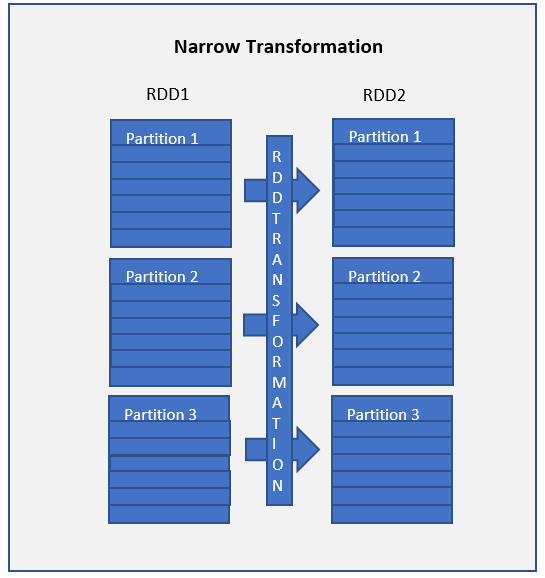

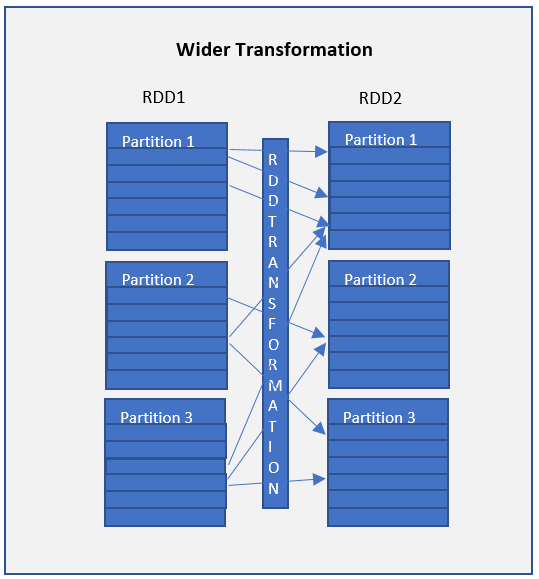

In [ ]:
def is_even(n):
    if n%2 == 0:
        return "even"
    else:
        return "odd"

rdd_even = spark.sparkContext.parallelize([(is_even(n), n) for n in range(10000000)])
rdd_even.take(5)

[('even', 0), ('odd', 1), ('even', 2), ('odd', 3), ('even', 4)]

#### Exercice 12 

Le RDD ci-dessus contient 5 millions de couples clé-valeur. La clé vaut "even" lorsque le nombre est pair, "odd" sinon. Dans les deux cellules suivantes, on ne veut conserver que les nombres multiples de 1 000 000 et de 1 000 001 (soit seulement 10 éléments) et retourner les sommes respectives des éléments pairs et impairs parmi eux.

Réalisez dans deux cellules différentes l'opération. Dans la première cellule, réalisez le `.reduceByKey` (fonction permettant de retourner un RDD avec le nombre d'occurences de la clé dans le RDD initial) APRÈS le `.filter`. Dans la seconde, faites l'inverse.

In [ ]:
rdd_filtered = rdd_even.filter(lambda x: x[1]%1000000==0 or x[1]%1000001==0).reduceByKey(lambda a,b : a+b)
rdd_filtered.collect()
# 4 secondes

[('even', 65000020), ('odd', 25000025)]

In [ ]:
rdd_filtered2 = rdd_even.reduceByKey(lambda a,b : a+b)
rdd_filtered2.collect()
# 6 secondes (dans ce cas, c'est plus long de faire une seule opération, que deux)

[('even', 24999995000000), ('odd', 25000000000000)]

### Aparté : le Natural Language Processing

Le [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) est le domaine de sciences permettant à des algorithmes de traiter du langage humain dit "naturel" afin d'en décortiquer son sens, d'en faire des analyses et d'en sortir une valeur ajoutée.

Parmi les différents domaines d'expertises du NLP, on retrouve notamment l'analyse de sentiments, qui permet de déterminer un score de "positivité" d'une phrase entre -1 et 1. Ainsi une phrase comme "je n'aime pas les fraises" sera plutôt négative avec un score proche de -1, et une phrase plus positive comme "j'adore les fraises" aura un score proche de 1.

En Python, des packages comme *nltk*, *textblob* ou *spacy* permettent de réaliser, clé en main, ce genre d'opérations.

Pour analyser les sentiments d'une phrase, il est d'abord important de supprimer les mots superflus n'apportant aucun sens réel à la phrase (tels que les déterminants, les conjonctions de coordinations, etc...). On appelle ces mots des *stop words*. Une fois qu'on aura retiré ces *stop words*, on pourra commencer l'analyse de sentiments.

#### Installation des paquets 

In [ ]:
!pip install textblob_fr

     |████████████████████████████████| 561 kB 7.6 MB/s 


In [ ]:
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import string
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

stop_words=set(STOP_WORDS)
deselect_stop_words = ['n\'', 'ne','pas','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in stop_words:
        stop_words.remove(w)
    else:
        continue

stop_words_new = []
for s in stop_words:
    stop_words_new.append(s.replace('’', "'"))
stop_words = set(stop_words_new)

#### L'analyse de sentiments

In [ ]:
stop_words

{'a',
 'abord',
 'absolument',
 'afin',
 'ah',
 'ai',
 'aie',
 'ailleurs',
 'ainsi',
 'ait',
 'allaient',
 'allo',
 'allons',
 'allô',
 'alors',
 'anterieur',
 'anterieure',
 'anterieures',
 'apres',
 'après',
 'as',
 'assez',
 'attendu',
 'au',
 'aujourd',
 "aujourd'hui",
 'aupres',
 'auquel',
 'aura',
 'auraient',
 'aurait',
 'auront',
 'aussi',
 'autre',
 'autrefois',
 'autrement',
 'autres',
 'autrui',
 'aux',
 'auxquelles',
 'auxquels',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avoir',
 'avons',
 'ayant',
 'bah',
 'bas',
 'basee',
 'bat',
 'beau',
 'beaucoup',
 'bien',
 'bigre',
 'boum',
 'bravo',
 'brrr',
 "c'",
 'car',
 'ce',
 'ceci',
 'cela',
 'celle',
 'celle-ci',
 'celle-là',
 'celles',
 'celles-ci',
 'celles-là',
 'celui',
 'celui-ci',
 'celui-là',
 'cent',
 'cependant',
 'certain',
 'certaine',
 'certaines',
 'certains',
 'certes',
 'ces',
 'cet',
 'cette',
 'ceux',
 'ceux-ci',
 'ceux-là',
 'chacun',
 'chacune',
 'chaque',
 'cher',
 'chers',
 'chez',
 'chiche',
 

Ci-dessus vous trouverez l'intégralité des stop words de la langue française auxquels on aura retiré de la liste les éléments de négation, important pour l'analyse de sentiments.

In [ ]:
s = "J'adore les fraises"
tb(s).sentiment[0]

0.5

In [ ]:
s2 = "Je n'aime pas du tout les fraises, je trouve ça affreux. Personne ne devrait aimer ça"
tb(s2).sentiment[0]

0.006666666666666636

Ci-dessus, vous trouverez le moyen de récupérer le score de "positivité" d'une phrase à partir du package *textblob*. Remplacez simplement `s` ou `s2` par une autre chaîne de caractères et vous pourrez ainsi analyser le sentiment d'une phrase.

#### TP : Analyse de sentiments de la pièce de théâtre "Le Cid" de Corneille

Avant tout, veuillez modifier les chemins d'accès suivants (conservez les chemins d'accès du professeur en commentaires de la cellule, pour faciliter la correction), afin de les adapter à l'emplacement du Cid dans votre Google Drive

In [ ]:
#le_cid_path = "/content/drive/MyDrive/Cours BigData Fintech/Datasets/Le Cid/CORNEILLEP_CID37.txt"
#le_cid_actes_path = [
#    "/content/drive/MyDrive/Cours BigData Fintech/Datasets/Le Cid/CORNEILLEP_CID37_ACTE_I.txt",
#    "/content/drive/MyDrive/Cours BigData Fintech/Datasets/Le Cid/CORNEILLEP_CID37_ACTE_II.txt",
#    "/content/drive/MyDrive/Cours BigData Fintech/Datasets/Le Cid/CORNEILLEP_CID37_ACTE_III.txt",
#    "/content/drive/MyDrive/Cours BigData Fintech/Datasets/Le Cid/CORNEILLEP_CID37_ACTE_IV.txt",
#    "/content/drive/MyDrive/Cours BigData Fintech/Datasets/Le Cid/CORNEILLEP_CID37_ACTE_V.txt"
#]

le_cid_path = "/content/drive/MyDrive/Le Cid/CORNEILLEP_CID37.txt"
le_cid_actes_path = [
    "/content/drive/MyDrive/Le Cid/CORNEILLEP_CID37_ACTE_I.txt",
    "/content/drive/MyDrive/Le Cid/CORNEILLEP_CID37_ACTE_II.txt",
    "/content/drive/MyDrive/Le Cid/CORNEILLEP_CID37_ACTE_III.txt",
    "/content/drive/MyDrive/Le Cid/CORNEILLEP_CID37_ACTE_IV.txt",
    "/content/drive/MyDrive/Le Cid/CORNEILLEP_CID37_ACTE_V.txt"
]

Sujet :

Vous commencerez par importer le premier acte du Cid sous forme de RDD.

Dans un premier temps, vous supprimerez toutes les lignes vides, les didascalies (tous les textes en majuscules) ainsi que tous les *stop words* de chacun des vers de ce premier acte.

Ensuite, en considérant une phrase "négative" comme ayant un score entre -1 et -0.3, une phrase neutre entre -0.3 et 0.4 et une phrase positive supérieure à 0.4, calculez le nombre de phrases positives, négatives et neutres ainsi que le score moyen de positivité de l'acte 1.

Faites ensuite la même chose pour les autres actes et sur le livre entier et comparez ces scores sur un graphique à barres (en utilisant la librairie graphique de votre choix).

In [ ]:
# Import du premier acte
chemin = le_cid_actes_path[0]
rdd = spark.sparkContext.textFile(chemin)
rdd.collect()

['\t\t\tACTE I',
 '',
 '',
 'SCÈNE PREMIÈRE. Le Comte, Elvire.',
 'ELVIRE.',
 'Entre tous ces amants dont la jeune ferveur',
 'Adore votre fille, et brigue ma faveur,',
 "Don Rodrigue et Don Sanche à l'envi font paraître",
 "Le beau feu qu'en leurs coeurs ses beautés ont fait naître,",
 "Ce n'est pas que Chimène écoute leurs soupirs,",
 "Ou d'un regard propice anime leurs désirs,",
 "Au contraire pour tous dedans l'indifférence",
 "Elle n'ôte à pas un, ni donne d'espérance,",
 "Et sans les voir d'un oeil trop sévère, ou trop doux,",
 "C'est de votre seul choix qu'elle attend un époux.",
 'LE COMTE.',
 "Elle est dans le devoir, tous deux sont dignes d'elle,",
 "Tous deux formés d'un sang, noble, vaillants, fidèle,",
 'Jeunes, mais qui font lire aisément dans leurs yeux',
 "L'éclatante vertu de leurs braves aïeux.",
 "Don Rodrigue sur tout n'a trait en son visage",
 "Qui d'un homme de coeur ne soit la haute image,",
 "Et sort d'une maison si féconde en guerriers,",
 "Qu'ils y prennent na

In [ ]:
# Suppression des lignes vides
# rdd = rdd.filter(lambda x: x != "").filter(lambda x: x.upper() != x)
# Pas besoin de faire les lignes vides et les didascalies séparemment, les deux se font avec cette condition :
# Le [:3] permet de faire en sorte que, s'il y a un mot en maj, on le supprime
# (on excepte de "A " qui a pour longueur 1, car existe dans les chaines classiques, comme "Ô", "À", etc)
# Les mots supprimés sont donc tous les mots comme : "A A", "AA ", "AAA" et toutes les extensions
rdd_filtre = rdd.map(lambda x: x.replace("\t", "")).filter(lambda x: x.upper()[:3] != x[:3])
rdd_filtre.collect()

['Entre tous ces amants dont la jeune ferveur',
 'Adore votre fille, et brigue ma faveur,',
 "Don Rodrigue et Don Sanche à l'envi font paraître",
 "Le beau feu qu'en leurs coeurs ses beautés ont fait naître,",
 "Ce n'est pas que Chimène écoute leurs soupirs,",
 "Ou d'un regard propice anime leurs désirs,",
 "Au contraire pour tous dedans l'indifférence",
 "Elle n'ôte à pas un, ni donne d'espérance,",
 "Et sans les voir d'un oeil trop sévère, ou trop doux,",
 "C'est de votre seul choix qu'elle attend un époux.",
 "Elle est dans le devoir, tous deux sont dignes d'elle,",
 "Tous deux formés d'un sang, noble, vaillants, fidèle,",
 'Jeunes, mais qui font lire aisément dans leurs yeux',
 "L'éclatante vertu de leurs braves aïeux.",
 "Don Rodrigue sur tout n'a trait en son visage",
 "Qui d'un homme de coeur ne soit la haute image,",
 "Et sort d'une maison si féconde en guerriers,",
 "Qu'ils y prennent naissance au milieu des lauriers,",
 'La valeur de son père, en son temps sans pareille,',
 "

In [ ]:
# Suppression des stop_words
def suppression_stop_words(chaine, stop_words):
  # On choisit de mettre toutes les phrases en minuscules (facilite le traitement après)
  chaine = chaine.replace("'", "' ").lower()
  for mot in stop_words:
    chaine = chaine.replace(" "+mot+" ", " ")
  return chaine
#print(suppression_stop_words(s2, stop_words))

rdd_new = rdd_filtre.map(lambda x: suppression_stop_words(x, stop_words))
rdd_new.collect()

['entre amants jeune ferveur',
 'adore fille, brigue faveur,',
 'don rodrigue don sanche envi paraître',
 'le feu coeurs beautés naître,',
 'ce pas chimène écoute soupirs,',
 'ou regard propice anime désirs,',
 'au contraire indifférence',
 'elle ôte pas un, ni donne espérance,',
 'et voir oeil sévère, doux,',
 "c' choix attend époux.",
 'elle devoir, dignes elle,',
 'tous formés sang, noble, vaillants, fidèle,',
 'jeunes, lire aisément yeux',
 "l' éclatante vertu braves aïeux.",
 'don rodrigue trait visage',
 'qui homme coeur ne haute image,',
 'et sort maison féconde guerriers,',
 "qu' y prennent naissance milieu lauriers,",
 'la valeur père, temps pareille,',
 'tant duré force merveille,',
 'ses rides front gravé exploits,',
 'et disent encor fut :',
 'je promets fils père,',
 'et fille mot aimer plaire.',
 'va entretenir, entretien',
 'cache sentiment découvre sien,',
 'je veux parlions ensemble ;',
 "l' heure présent appelle conseil assemble,",
 'le roi fils choisir gouverneur,',


In [ ]:
# Calcul de tous les scores du RDD
rdd_notes = rdd_new.map(lambda x: (tb(x).sentiment[0], x))
rdd_notes.collect()  

[(0.32, 'entre amants jeune ferveur'),
 (0.5, 'adore fille, brigue faveur,'),
 (0.0, 'don rodrigue don sanche envi paraître'),
 (0.0, 'le feu coeurs beautés naître,'),
 (0.0, 'ce pas chimène écoute soupirs,'),
 (0.2, 'ou regard propice anime désirs,'),
 (-0.1, 'au contraire indifférence'),
 (0.0, 'elle ôte pas un, ni donne espérance,'),
 (0.07500000000000001, 'et voir oeil sévère, doux,'),
 (0.0, "c' choix attend époux."),
 (0.5, 'elle devoir, dignes elle,'),
 (0.20666666666666667, 'tous formés sang, noble, vaillants, fidèle,'),
 (0.32, 'jeunes, lire aisément yeux'),
 (0.5, "l' éclatante vertu braves aïeux."),
 (0.0, 'don rodrigue trait visage'),
 (0.05500000000000001, 'qui homme coeur ne haute image,'),
 (-0.07, 'et sort maison féconde guerriers,'),
 (0.0, "qu' y prennent naissance milieu lauriers,"),
 (0.0, 'la valeur père, temps pareille,'),
 (0.4, 'tant duré force merveille,'),
 (0.0, 'ses rides front gravé exploits,'),
 (0.0, 'et disent encor fut :'),
 (0.0, 'je promets fils père,

In [ ]:
# On définit la positivité en fonction du score
def positivite(score):
  chaine = "neutre"
  if (score < -0.3):
    chaine = "négative"
  elif (score > 0.4):
    chaine = "positive"
  return chaine

rdd_positivite = rdd_notes.map(lambda x: (positivite(x[0]), x[0], x[1], 1))
rdd_positivite.collect()  

[('neutre', 0.32, 'entre amants jeune ferveur', 1),
 ('positive', 0.5, 'adore fille, brigue faveur,', 1),
 ('neutre', 0.0, 'don rodrigue don sanche envi paraître', 1),
 ('neutre', 0.0, 'le feu coeurs beautés naître,', 1),
 ('neutre', 0.0, 'ce pas chimène écoute soupirs,', 1),
 ('neutre', 0.2, 'ou regard propice anime désirs,', 1),
 ('neutre', -0.1, 'au contraire indifférence', 1),
 ('neutre', 0.0, 'elle ôte pas un, ni donne espérance,', 1),
 ('neutre', 0.07500000000000001, 'et voir oeil sévère, doux,', 1),
 ('neutre', 0.0, "c' choix attend époux.", 1),
 ('positive', 0.5, 'elle devoir, dignes elle,', 1),
 ('neutre',
  0.20666666666666667,
  'tous formés sang, noble, vaillants, fidèle,',
  1),
 ('neutre', 0.32, 'jeunes, lire aisément yeux', 1),
 ('positive', 0.5, "l' éclatante vertu braves aïeux.", 1),
 ('neutre', 0.0, 'don rodrigue trait visage', 1),
 ('neutre', 0.05500000000000001, 'qui homme coeur ne haute image,', 1),
 ('neutre', -0.07, 'et sort maison féconde guerriers,', 1),
 ('neu

In [ ]:
# On réduit le RDD en deux dimensions pour faciliter le comptage
rdd_reduite = rdd_positivite.map(lambda x: (x[0], 1))
print("RDD réduit aux paramètres utiles : ", rdd_reduite.collect())

# Comptage des arguments
rdd_positivite_reduce = rdd_reduite.reduceByKey(lambda a,b : a+b)
print("Réduce by key : ", rdd_positivite_reduce.collect())

def calcul_moyenne(rdd):
  val = 0
  total = 0
  for i in range(len(rdd)):
    if (rdd[i][0] == "positive"):
      val = rdd[i][1]
    total += rdd[i][1]
  return (val/total)

proportion_acte_un = calcul_moyenne(rdd_positivite_reduce.collect())
proportion_acte_un_pourcentage = proportion_acte_un * 100
print("Proportion des positives acte 1 :" + str(proportion_acte_un_pourcentage) + "%")

RDD réduit aux paramètres utiles :  [('neutre', 1), ('positive', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('positive', 1), ('neutre', 1), ('neutre', 1), ('positive', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('positive', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('positive', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('négative', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('neutre', 1), ('négative', 1), ('négative', 1), ('positive', 1), ('neutre', 1), 

In [ ]:
# On ajoute le résultat du premier acte au tableau des res
tab_pourcentages = [proportion_acte_un_pourcentage]

# On fait la même chose sur les autres actes
for i in range(1, len(le_cid_actes_path)):
  # Import du premier acte
  chemin = le_cid_actes_path[i]
  rdd = spark.sparkContext.textFile(chemin)
  rdd_filtre = rdd.map(lambda x: x.replace("\t", "")).filter(lambda x: x.upper()[:3] != x[:3])
  rdd_new = rdd_filtre.map(lambda x: suppression_stop_words(x, stop_words))
  rdd_notes = rdd_new.map(lambda x: (tb(x).sentiment[0], x))
  rdd_positivite = rdd_notes.map(lambda x: (positivite(x[0]), x[0], x[1], 1))
  # On réduit le RDD en deux dimensions pour faciliter le comptage
  rdd_reduite = rdd_positivite.map(lambda x: (x[0], 1))

  # Comptage des arguments
  rdd_positivite_reduce = rdd_reduite.reduceByKey(lambda a,b : a+b)
  proportion_acte = calcul_moyenne(rdd_positivite_reduce.collect())
  proportion_acte_pourcentage = proportion_acte * 100
  tab_pourcentages.append(proportion_acte_pourcentage)

print("Tableau des pourcentages des phrases positives :", tab_pourcentages)

Tableau des pourcentages des phrases positives : [7.3569482288828345, 6.572769953051644, 9.186351706036746, 7.008086253369273, 6.565656565656567]


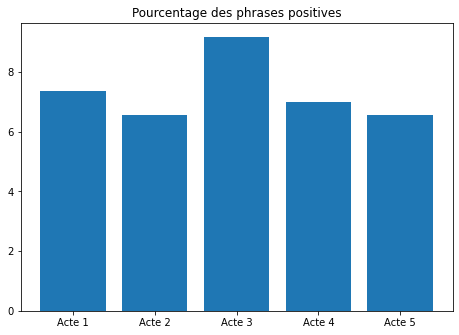

In [ ]:
# Graphique :
import matplotlib.pyplot as plt

# création chaine de légendes :
chaine_titres = "Acte "
tab_titres = []
for i in range(1, len(le_cid_actes_path) + 1):
  tab_titres.append(chaine_titres + str(i))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tab_titres,tab_pourcentages)
ax.set_title("Pourcentage des phrases positives")
plt.show()

## Section 3 - Les DataFrames Spark

Les RDDs permettent de créer des collections d'objets parallélisées, et dont l'accès et la récolte sont optimisés par le moteur de Spark. Cependant, il s'agit de la manière la plus générique pour accéder à de la donnée via Spark.

Spark, pour le traitement de données tabulaires, propose une surcouche aux RDDs, nommée les DataFrames. D'une utilisation très similaire à un Pandas DataFrame, les Spark DataFrames tirent avantage de la même manière que les RDDs d'une distribution optimisée de la donnée sur divers noeuds.

### 1 - Créer un Spark DataFrame

Il existe plusieurs moyens de créer un DataFrame en Spark. Pour faire la transition depuis ce que nous avons appliqué jusque là, il est possible d'exporter un RDD tabulaire vers un DataFrame via la fonction `.toDF`.

In [ ]:
rdd_table = spark.sparkContext.parallelize([
    ["Chien", "Mammifère", 80],
    ["Coccinnelle", "Insecte", 1],
    ["Crabe", "Crustacé", None]
])

df = rdd_table.toDF()
df.show(truncate=False)
# La fonction show permet de montrer le contenue partiel d'un DF,
# le paramètre truncate à False permet d'afficher l'intégralité du DF

+-----------+---------+----+
|_1         |_2       |_3  |
+-----------+---------+----+
|Chien      |Mammifère|80  |
|Coccinnelle|Insecte  |1   |
|Crabe      |Crustacé |null|
+-----------+---------+----+



In [ ]:
df.printSchema()
# La fonction printSchema permet de se rendre compte de quel type de données
# est constitué chaque colonne du DataFrame

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



Comme vous pouvez le constater, les cellules ci-dessus ont créé un DataFrame avec trois colonnes `_1`, `_2` et `_3`, en inférant automatiquement le type de données de chacune des colonnes : les deux premières colonnes sont bien des chaînes de caractères et la troisième un entier (de type `long`) nullable.

En passant une liste de chaînes de caractères en paramètres de la fonction `.toDF`, il est possible de spécifier les noms des colonnes.

#### Exercice 13
Créez un RDD de format tabulaire et transformez-le en Spark DataFrame, en spécifiant des noms de colonnes.

In [ ]:
df = rdd_table.toDF(["Animal", "Famille", "Poids"])
df.show(truncate=False)

+-----------+---------+-----+
|Animal     |Famille  |Poids|
+-----------+---------+-----+
|Chien      |Mammifère|80   |
|Coccinnelle|Insecte  |1    |
|Crabe      |Crustacé |null |
+-----------+---------+-----+



Dans les exemples précédents, Spark a détecté automatiquement le type des colonnes, et a aussi déduit automatiquement si un champ avait le droit d'être nullable ou non. Cependant, Spark utilise une stratégie de type "ne prenons pas de risques" et inférera systématiquement des types parfois surdimensionné au besoin et, sauf si le contraire est spécifié, laissera l'opportunité de remplir les champs de valeurs nulles (`None` en Python).

Pour pallier à cela, il est possible de spécifier un schéma à la création d'un DataFrame, en procédant comme l'exemple suivant.

In [ ]:
rdd_table = spark.sparkContext.parallelize([
    ["Chien", "Mammifère", 80],
    ["Coccinnelle", "Insecte", 1],
    ["Crabe", "Crustacé", None]
])

from pyspark.sql.types import StructType, StructField, StringType, ShortType, DoubleType, IntegerType, ArrayType, FloatType

schema = StructType([
    StructField("animal", StringType(), False),
    StructField("type", StringType(), False),
    StructField("taille_en_cm", ShortType(), True)
])

df = rdd_table.toDF(schema=schema)

In [ ]:
df.show()

+-----------+---------+------------+
|     animal|     type|taille_en_cm|
+-----------+---------+------------+
|      Chien|Mammifère|          80|
|Coccinnelle|  Insecte|           1|
|      Crabe| Crustacé|        null|
+-----------+---------+------------+



In [ ]:
df.printSchema()

root
 |-- animal: string (nullable = false)
 |-- type: string (nullable = false)
 |-- taille_en_cm: short (nullable = true)



Pour définir un schéma on utilise l'objet importé du sous-package `pyspark.sql.types` nommé `StructType`, qui est composé de `StructField`. Chaque `StructField` prend 3 paramètres :     


*   Le nom du champ
*   Le type du champ
*   Un booléen qui permet de savoir si un champ est nullable ou non (dans ce cas `None` sera une valeur acceptable, quelque soit le type de la colonne)

Vous pourrez retrouver la liste des types disponibles [dans la documentation Spark associée](https://spark.apache.org/docs/latest/sql-ref-datatypes.html).

Dans notre cas, supposant qu'un animal ne peut excéder 3000cm, il est suffisant d'utiliser le type d'entier `short`, qui code l'entier sur 2 octets (les valeurs possibles sont entre -32768 et 32767).

Un autre avantage des DataFrames Spark, c'est qu'il ne s'arrête pas à de la donnée tabulaire à deux dimensions. Une colonne peut tout à fait avoir les types suivants :       


*   `ArrayType([elementType])` : les éléments de la colonne seront donc des tableaux d'un type défini en paramètre de l'`ArrayType`
*   `MapType([keyType], [elementType])` : les éléments de la colonne seront alors des dictionnaires dont la clé sera de type `keyType` et la colonne de type `elementType`.

Les types d'un `ArrayType` ou d'un `MapType` à spécifier sont issus du même sous-package `pyspark.sql.types`.



#### Exercice 14

Créez un RDD tabulaire de dix élèves. Le premier et second champs seront les nom et prénom de l'élève, le troisième une liste d'entre 3 et 6 notes (des nombres réels entre 0 et 20). 

En spécifiant le schéma, transformez ensuite ce RDD en Spark DataFrame.

In [ ]:
# Installation de la biblio names pour créer des noms au hasard
!pip install names

     |████████████████████████████████| 789 kB 5.6 MB/s 
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=79b80cc42ecd99430d5d93f148ae4c70f452856fd8fb8b718cfcd3ffa6650d43
  Stored in directory: /root/.cache/pip/wheels/05/ea/68/92f6b0669e478af9b7c3c524520d03050089e034edcc775c2b
Successfully built names


In [ ]:
import random
import names

# Génération des noms, prénoms et notes aléatoires
tab = []
for i in range(20):
  tab.append([names.get_first_name(), names.get_last_name(), [round(random.random()*20.0, 2),round(random.random()*20.0, 2),round(random.random()*20.0, 2)]])

rdd_table = spark.sparkContext.parallelize(tab)

schema = StructType([
    StructField("Nom", StringType(), False),
    StructField("Prénom", StringType(), False),
    StructField("Notes", ArrayType(FloatType()), False)
])

df = rdd_table.toDF(schema=schema)

In [ ]:
df.printSchema()

root
 |-- Nom: string (nullable = false)
 |-- Prénom: string (nullable = false)
 |-- Notes: array (nullable = false)
 |    |-- element: float (containsNull = true)



In [ ]:
df.show()

+-----------+---------+--------------------+
|        Nom|   Prénom|               Notes|
+-----------+---------+--------------------+
|      David| Robinson|[16.42, 14.95, 6.64]|
|   Michelle| Montello| [19.09, 0.83, 3.43]|
|    Fredric|      Key| [15.46, 3.26, 0.06]|
|       Marc| Thompson|   [1.6, 4.4, 16.18]|
|Christopher|    Jones| [5.76, 16.71, 9.06]|
|    Kenneth|    Coble|  [13.12, 7.54, 9.4]|
|    Melissa| Shepherd|[10.9, 12.89, 17.86]|
|      Jacob|  Ramirez|[18.19, 12.81, 12...|
|        Ida|   Juares| [18.2, 9.64, 12.29]|
|     Samuel|  Roberts|[17.04, 18.76, 0.92]|
|    Kenneth|  Adamson|[13.49, 7.92, 17.19]|
|      Haley|   Taylor| [5.31, 1.25, 19.15]|
|      Andre|   Howard|[15.15, 6.07, 16.58]|
|   Margaret|     Sato| [13.64, 5.37, 1.73]|
|      Clyde|  Shelley| [5.56, 15.19, 8.13]|
|      Tracy| Lawrence|   [6.5, 4.18, 6.52]|
|     Martha|   Morgan|   [6.88, 0.7, 1.69]|
|       Raul|Hernandez|[15.08, 2.03, 14.51]|
|      Marva|  Wheeler| [10.43, 7.83, 2.34]|
|       Ji

### 2 - Le format *Parquet*

Afin de conserver l'avantage du partitionnement de données, Spark définit par défaut un format de lecture/écriture de ses DataFrames nommé *Parquet*. En réalité, ce format est hérité d'Hadoop, technologie de l'Apache Foundation sur laquelle Spark repose.

Pour sauvegarder un DataFrame au format *Parquet*, on utilisera la fonction `.write.save([chemin_de_sauvegarde_du_fichier])` appliquée à un DataFrame.

De la même manière, on utilisera la fonction `spark.read.load([emplacement_du_fichier])` pour lire un fichier *.parquet* et en faire un Spark DataFrame.

#### Exercice 15

Sauvegardez le DataFrame créé à l'exercice 14 en fichier *.parquet*, puis rechargez-le dans un nouveau DataFrame. Affichez le nouveau DataFrame ainsi que son schéma.

In [ ]:
!rm -r "/content/drive/MyDrive/test.parquet"

In [ ]:
chemin = "/content/drive/MyDrive/test.parquet"
df.write.save(chemin)

In [ ]:
df_import = spark.read.load(chemin)
df_import

DataFrame[Nom: string, Prénom: string, Notes: array<float>]

In [ ]:
df_import.show()

+-----------+---------+--------------------+
|        Nom|   Prénom|               Notes|
+-----------+---------+--------------------+
|      David| Robinson|[16.42, 14.95, 6.64]|
|   Michelle| Montello| [19.09, 0.83, 3.43]|
|    Fredric|      Key| [15.46, 3.26, 0.06]|
|       Marc| Thompson|   [1.6, 4.4, 16.18]|
|Christopher|    Jones| [5.76, 16.71, 9.06]|
|    Kenneth|    Coble|  [13.12, 7.54, 9.4]|
|    Melissa| Shepherd|[10.9, 12.89, 17.86]|
|      Jacob|  Ramirez|[18.19, 12.81, 12...|
|        Ida|   Juares| [18.2, 9.64, 12.29]|
|     Samuel|  Roberts|[17.04, 18.76, 0.92]|
|    Kenneth|  Adamson|[13.49, 7.92, 17.19]|
|      Haley|   Taylor| [5.31, 1.25, 19.15]|
|      Andre|   Howard|[15.15, 6.07, 16.58]|
|   Margaret|     Sato| [13.64, 5.37, 1.73]|
|      Clyde|  Shelley| [5.56, 15.19, 8.13]|
|      Tracy| Lawrence|   [6.5, 4.18, 6.52]|
|     Martha|   Morgan|   [6.88, 0.7, 1.69]|
|       Raul|Hernandez|[15.08, 2.03, 14.51]|
|      Marva|  Wheeler| [10.43, 7.83, 2.34]|
|       Ji

### 3 - Importer un DataFrame depuis des sources diverses

Spark permet d'importer des données depuis divers formats : CSV, JSON et bien d'autres. Nous nous intéresserons principalement au format CSV, assez courant dans le monde de la donnée tabulaire. Si vous souhaitez approfondir et explorer d'autres formats, vous trouverez au lien suivant [la documentation Spark associée aux différentes sources de données](https://spark.apache.org/docs/latest/sql-data-sources.html).

La manière la plus simple d'importer un fichier CSV est d'utiliser la fonction `.csv` du sous-package `spark.read` comme ci-dessous. 

In [ ]:
df = spark.read.csv('sample_data/california_housing_test.csv')
df.show()

+-----------+---------+------------------+-----------+--------------+-----------+----------+-------------+------------------+
|        _c0|      _c1|               _c2|        _c3|           _c4|        _c5|       _c6|          _c7|               _c8|
+-----------+---------+------------------+-----------+--------------+-----------+----------+-------------+------------------+
|  longitude| latitude|housing_median_age|total_rooms|total_bedrooms| population|households|median_income|median_house_value|
|-122.050000|37.370000|         27.000000|3885.000000|    661.000000|1537.000000|606.000000|     6.608500|     344700.000000|
|-118.300000|34.260000|         43.000000|1510.000000|    310.000000| 809.000000|277.000000|     3.599000|     176500.000000|
|-117.810000|33.780000|         27.000000|3589.000000|    507.000000|1484.000000|495.000000|     5.793400|     270500.000000|
|-118.360000|33.820000|         28.000000|  67.000000|     15.000000|  49.000000| 11.000000|     6.135900|     330000.

Comme vous pouvez le constater cependant, la première ligne du CSV qui normalement sert de noms de colonnes a été lue comme de la donnée. Pour cela, il est possible de spécifier certaines options de lectures à Spark avant d'appliquer la fonction `.csv`, via la fonction `.options`, comme ci-dessous. Vous retrouverez la liste de toutes les options de lecture dans la [documentation Spark associée](https://spark.apache.org/docs/latest/sql-data-sources-csv.html).

In [ ]:
df = spark.read.options(header=True).csv([
    "sample_data/california_housing_test.csv",
    "sample_data/california_housing_train.csv"
])
df.show()

+-----------+---------+------------------+-----------+--------------+-----------+-----------+-------------+------------------+
|  longitude| latitude|housing_median_age|total_rooms|total_bedrooms| population| households|median_income|median_house_value|
+-----------+---------+------------------+-----------+--------------+-----------+-----------+-------------+------------------+
|-114.310000|34.190000|         15.000000|5612.000000|   1283.000000|1015.000000| 472.000000|     1.493600|      66900.000000|
|-114.470000|34.400000|         19.000000|7650.000000|   1901.000000|1129.000000| 463.000000|     1.820000|      80100.000000|
|-114.560000|33.690000|         17.000000| 720.000000|    174.000000| 333.000000| 117.000000|     1.650900|      85700.000000|
|-114.570000|33.640000|         14.000000|1501.000000|    337.000000| 515.000000| 226.000000|     3.191700|      73400.000000|
|-114.570000|33.570000|         20.000000|1454.000000|    326.000000| 624.000000| 262.000000|     1.925000|    

Comme vous pouvez le constater ci-dessus, il est aussi possible de spécifier une liste d'emplacements, Spark lira alors tous les CSV spécifiés et concaténera tous les CSV en un seul DataFrame. De la même manière, vous pouvez spécifier le chemin d'un répertoire, tous les CSV de ce répertoire seront alors lu.

In [ ]:
df.printSchema()

root
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- housing_median_age: string (nullable = true)
 |-- total_rooms: string (nullable = true)
 |-- total_bedrooms: string (nullable = true)
 |-- population: string (nullable = true)
 |-- households: string (nullable = true)
 |-- median_income: string (nullable = true)
 |-- median_house_value: string (nullable = true)



L'ennui c'est qu'ici, Spark n'infère pas automatiquement le type de nos champs. Il est possible en utilisant la fonciton `.schema([schema_a_specifier])` (avant la fonction `.csv`) de spécifier un schéma tel que nous l'avons découvert plus haut.

#### Exercice 16

Définissez un schéma pertinent aux fichiers CSV des habitations californiennes, puis relisez-les en forçant ce schéma à la lecture.

In [ ]:
schema = StructType([
    StructField("longitude", DoubleType(), False),
    StructField("latitude", DoubleType(), False),
    StructField("housing_median_age", DoubleType(), False),
    StructField("total_rooms", DoubleType(), False),
    StructField("total_bedrooms", DoubleType(), False),
    StructField("population", DoubleType(), False),
    StructField("households", DoubleType(), False),
    StructField("median_income", DoubleType(), False),
    StructField("median_house_value", DoubleType(), False),
])
df_type = spark.read.options(header=True).schema(schema).csv([
    "sample_data/california_housing_test.csv",
    "sample_data/california_housing_train.csv"
])            
df_type.show()
                                                    

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           73400.0|
|  -114.57|   33.57|              20.0|     1454.0|         326.0|     624.0|     262.0|        1.925|           65500.0|
|  -114.58|   33.63|    

### 4 - Sélectionner des données

Pour sélectionner des données, vous devez utiliser la fonction `.select` appliquée sur un DataFrame.

Son utilisation se fait de cette manière :

In [ ]:
df = spark.read.options(header=True).csv([
    "sample_data/california_housing_test.csv",
    "sample_data/california_housing_train.csv"
])
df.printSchema()

root
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- housing_median_age: string (nullable = true)
 |-- total_rooms: string (nullable = true)
 |-- total_bedrooms: string (nullable = true)
 |-- population: string (nullable = true)
 |-- households: string (nullable = true)
 |-- median_income: string (nullable = true)
 |-- median_house_value: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col, avg

sub_df = df.select(col("longitude"), col('latitude'))
sub_df.show()

+-----------+---------+
|  longitude| latitude|
+-----------+---------+
|-114.310000|34.190000|
|-114.470000|34.400000|
|-114.560000|33.690000|
|-114.570000|33.640000|
|-114.570000|33.570000|
|-114.580000|33.630000|
|-114.580000|33.610000|
|-114.590000|34.830000|
|-114.590000|33.610000|
|-114.600000|34.830000|
|-114.600000|33.620000|
|-114.600000|33.600000|
|-114.610000|34.840000|
|-114.610000|34.830000|
|-114.630000|32.760000|
|-114.650000|34.890000|
|-114.650000|33.600000|
|-114.650000|32.790000|
|-114.660000|32.740000|
|-114.670000|33.920000|
+-----------+---------+
only showing top 20 rows



La fonction `col` de Spark parcourt la liste des colonnes du DataFrame (accessible via l'attribut `.columns` associé à un DataFrame). Notez que vous pouvez aussi utiliesr directement les colonnes sans passer par la fonction `col`, en sélectionnant directement dans la liste des colonnes la colonne adéquate, ou en utilisant le nom de la colonne appliqué au DataFrame (ex : `col(maCol)` et `mon_df.maCol` reviennent au même dans notre cas).

Il est aussi important de noter que cette opération de sélection, tout comme pour les RDDs, retourne un nouveau DataFrame, un Spark DataFrame étant immutable.

#### Exercice 17

En reprenant le DataFrame généré dans l'exercice 16, sélectionner les colonnes de revenu médian et du prix médian des habitations, de trois manières différentes.

In [ ]:
taille_df = len(df_type.columns)
df_type_sub1 = df_type.select(col("median_income"), col('median_house_value'))
df_type_sub2 = df_type.select(df_type.median_income, df_type.median_house_value)
df_type_sub3 = df_type.select(df_type[taille_df-1], df_type[taille_df-2])

In [ ]:
df_type_sub1.show()

+-------------+------------------+
|median_income|median_house_value|
+-------------+------------------+
|       1.4936|           66900.0|
|         1.82|           80100.0|
|       1.6509|           85700.0|
|       3.1917|           73400.0|
|        1.925|           65500.0|
|       3.3438|           74000.0|
|       2.6768|           82400.0|
|       1.7083|           48500.0|
|       2.1782|           58400.0|
|       2.1908|           48100.0|
|       2.6797|           86500.0|
|        1.625|           62000.0|
|       2.1571|           48600.0|
|        3.212|           70400.0|
|       0.8585|           45000.0|
|       1.6991|           69100.0|
|       2.9653|           94900.0|
|       0.8571|           25000.0|
|       1.2049|           44000.0|
|       1.2656|           27500.0|
+-------------+------------------+
only showing top 20 rows



In [ ]:
df_type_sub2.show()

+-------------+------------------+
|median_income|median_house_value|
+-------------+------------------+
|       1.4936|           66900.0|
|         1.82|           80100.0|
|       1.6509|           85700.0|
|       3.1917|           73400.0|
|        1.925|           65500.0|
|       3.3438|           74000.0|
|       2.6768|           82400.0|
|       1.7083|           48500.0|
|       2.1782|           58400.0|
|       2.1908|           48100.0|
|       2.6797|           86500.0|
|        1.625|           62000.0|
|       2.1571|           48600.0|
|        3.212|           70400.0|
|       0.8585|           45000.0|
|       1.6991|           69100.0|
|       2.9653|           94900.0|
|       0.8571|           25000.0|
|       1.2049|           44000.0|
|       1.2656|           27500.0|
+-------------+------------------+
only showing top 20 rows



In [ ]:
df_type_sub3.show()

+------------------+-------------+
|median_house_value|median_income|
+------------------+-------------+
|           66900.0|       1.4936|
|           80100.0|         1.82|
|           85700.0|       1.6509|
|           73400.0|       3.1917|
|           65500.0|        1.925|
|           74000.0|       3.3438|
|           82400.0|       2.6768|
|           48500.0|       1.7083|
|           58400.0|       2.1782|
|           48100.0|       2.1908|
|           86500.0|       2.6797|
|           62000.0|        1.625|
|           48600.0|       2.1571|
|           70400.0|        3.212|
|           45000.0|       0.8585|
|           69100.0|       1.6991|
|           94900.0|       2.9653|
|           25000.0|       0.8571|
|           44000.0|       1.2049|
|           27500.0|       1.2656|
+------------------+-------------+
only showing top 20 rows



Vous pouvez aussi sélectionner toutes les colonnes présentant une expression régulière spécifique via la fonction [`.colRegex`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.colRegex.html).

#### Exercice 18
Via la fonction `.colRegex`, extrayez toutes les colonnes parlant de médiane et de totaux (commençant soit par "total" soit par "median").

Vous pouvez vous aider de cet [éditeur de regex](https://regex101.com/) pour vous assister dans la démarche.

In [ ]:
df_type_sub_regex = df_type.select(df_type.colRegex("`(total)+?.+`"), df_type.colRegex("`(median)+?.+`"))
df_type_sub_regex.show()

+-----------+--------------+-------------+------------------+
|total_rooms|total_bedrooms|median_income|median_house_value|
+-----------+--------------+-------------+------------------+
|     5612.0|        1283.0|       1.4936|           66900.0|
|     7650.0|        1901.0|         1.82|           80100.0|
|      720.0|         174.0|       1.6509|           85700.0|
|     1501.0|         337.0|       3.1917|           73400.0|
|     1454.0|         326.0|        1.925|           65500.0|
|     1387.0|         236.0|       3.3438|           74000.0|
|     2907.0|         680.0|       2.6768|           82400.0|
|      812.0|         168.0|       1.7083|           48500.0|
|     4789.0|        1175.0|       2.1782|           58400.0|
|     1497.0|         309.0|       2.1908|           48100.0|
|     3741.0|         801.0|       2.6797|           86500.0|
|     1988.0|         483.0|        1.625|           62000.0|
|     1291.0|         248.0|       2.1571|           48600.0|
|     24

### 5 - Créer des colonnes à la volée

La génération d'une nouvelle colonne dans un DataFrame existant n'est en réalité pas possible, de par son immutabilité. Pour cela, il faut donc recréer un DataFrame en y rajoutant une nouvelle colonne.

Cependant, plutôt que de faire cette opération qui occuperait de l'espace disque, et si la situation nous le permet, il est possible de créer des colonnes calculées à partir de colonnes originales du DF, via la fonction `.withColumn` appliquée à un DF. Vous retrouverez un exemple d'utilisation dans la [documentation associée](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html).

#### Exercice 19

Créer une nouvelle colonne qui correspondra à la différence entre le revenu median d'une municipalité avec le revenu médian californien. (Voir [cette fonction](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.approxQuantile.html) pour calculer une médiane approchée en Spark)

In [ ]:
mediane_approchee = df_type.approxQuantile("median_income", [0.5], 0.25)[0]
print("Mediane approchée : ",mediane_approchee)
df_type_sub_new_column = df_type.withColumn("Difference", df_type.median_income - mediane_approchee)
df_type_sub_new_column.show()

Mediane approchée :  2.5625
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|          Difference|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+--------------------+
|  -114.31|   34.19|              15.0|     5612.0|        1283.0|    1015.0|     472.0|       1.4936|           66900.0|             -1.0689|
|  -114.47|    34.4|              19.0|     7650.0|        1901.0|    1129.0|     463.0|         1.82|           80100.0| -0.7424999999999999|
|  -114.56|   33.69|              17.0|      720.0|         174.0|     333.0|     117.0|       1.6509|           85700.0|             -0.9116|
|  -114.57|   33.64|              14.0|     1501.0|         337.0|     515.0|     226.0|       3.1917|           7

### 6 - Filtrer des données

Tout comme dans Pandas, il est possible de filtrer des données selon des prédicats. Pour cela on peut le faire de trois différentes :     


*   En utilisant la fonction `.filter` avec une expression booléenne
*   En utilisant la fonction `.filter` avec une chaîne de caractères présentant un filtre écrit en SQL
*   Comme en Pandas, en écrivant entre crochets le filtre booléen (exemple : `df[df.nom == "Pierre"]`)

Nous nous concentrerons principelement sur les première et troisième manières de procéder (qui sont identiques).

Notez quelques fonctions qui vous permettront de réaliser des opérations booléenne dans ces filtres :     


*   [`.isin`](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.Column.isin.html)
*   [`.endswith`](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.Column.endswith.html) et [`.startsWith`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.startswith.html)
*   [`.contains`](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.Column.contains.html)
*   [`.like`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.like.html)

Il existe bien d'autres fonctions de ce genre, je vous invite à les retrouver dans cette [documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.html).


 


 #### Exercice 20
 Calculez la moyenne des revenus des municipalités dont le prix médian de l'habitation est situé entre 400 et 450k$.

In [ ]:
df_type_filtre = df_type.filter(df_type.median_house_value >= 400000).filter(df_type.median_house_value <= 450000)
df_type_filtre.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -116.44|   33.74|               5.0|      846.0|         249.0|     117.0|      67.0|       7.9885|          403300.0|
|   -117.0|   33.29|              17.0|     2073.0|         313.0|     573.0|     221.0|       8.2531|          419200.0|
|  -117.04|    32.9|               6.0|     6525.0|         826.0|    3146.0|     806.0|       9.2858|          436100.0|
|  -117.05|   33.04|              12.0|     1840.0|         254.0|     580.0|     234.0|       6.7769|          400000.0|
|  -117.05|   33.01|              17.0|     3430.0|         425.0|    1468.0|     433.0|      10.6186|          429300.0|
|  -117.07|   33.07|    

In [ ]:
df_type_moyenne = df_type_filtre.select(avg("median_income"))
df_type_moyenne.show()

+------------------+
|avg(median_income)|
+------------------+
| 5.652817600000005|
+------------------+



Notez qu'il n'existe pas de fonction `.map` associée à un DataFrame Spark, il faut donc utiliser son RDD (accessible via l'attribut `.rdd`) pour faire une telle opération.

Il existe aussi d'autres fonctions associées aux DataFrames permettant d'extraire des indicateurs de manière optimisée, trouvable dans cette [documentation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.html).